In [73]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict
import seaborn as sns
sns.set_palette("colorblind")

In [74]:
os.chdir("/Users/edwardgan/Documents/Projects/sketchstore/python")

In [75]:
import sketch.compress_freq
import sketch.sketch_frequent
import sketch.compress_dyadic
import sketch.sketch_gen
import storyboard.board_gen

In [113]:
colormap = {
    "cooperative": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "dyadic_b2": "C6",
    
    "dyadic_b4": "C1",
    "dyadic_b10": "C2",

    "q_cooperative": "C0",
    "q_truncation": "C1",
    "q_pps": "C2",
    "q_random_sample": "C3",
    "q_dyadic_b2": "C6",
    
    "spacesaving": "C4",
    "cms_min": "C5",
    "kll": "C4",
}
markers = {
    "cooperative": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    
    "dyadic_b2": "<",
    "dyadic_b4": "^",
    "dyadic_b10": "+",

    "q_cooperative": "x",
    "q_truncation": "^",
    "q_pps": "s",
    "q_random_sample": "+",
    "q_dyadic_b2": "<",

    "spacesaving": "D",
    "cms_min": "o",
    "kll": "D",
}
alg_display_name = {
    "cooperative": "Cooperative",
    "truncation": "Truncation",
    "pps": "PPS",
    "random_sample": "USample",
    
    "dyadic_b2": "Hierachy $b=2$",
    "dyadic_b4": "Hierachy $b=4$",
    "dyadic_b10": "Hierachy $b=10$",

    "q_cooperative": "Cooperative",
    "q_truncation": "Truncation",
    "q_pps": "PPS",
    "q_random_sample": "USample",
    "q_dyadic_b2": "Hierachy $b=2$",

    "spacesaving": "SpaceSaving",
    "cms_min": "CMS",
    "kll": "KLL",
}
data_display_name = {
    "caida_10M": "CAIDA",
    "zipf1p1_10M": "Zipf",
    "msft_network_3M": "Service:Provider",
    "msft_os_3M": "Service:OSBuild",
    "power_2M": "Power",
    "uniform_1M": "Uniform",
    "msft_records_3M": "Service:Traffic",
}

In [91]:
def get_error_file(dataset_name, granularity, sketch_name, sketch_size):
    return os.path.join(
        "output/boards/{}_{}/".format(dataset_name,granularity),
        "{}_{}_errors.csv".format(sketch_name, sketch_size)
    )

# Multi Dataset

In [124]:
def query_length_plot(
    dataset_name,
    granularity,
    sketch_names: List,
    sketch_size,
    item_agg="max",
    query_agg="mean",
    ax = None,
    absolute=False,
):
    e_fnames = [
        get_error_file(
        dataset_name, granularity, cur_name, sketch_size
        )
        for cur_name in sketch_names
    ]
    e_dfs = [pd.read_csv(f) for f in e_fnames]
    e_combined = pd.concat(e_dfs, axis=0)
    e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    if absolute:
        e_combined["e_norm"] = e_combined[item_agg]
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "e_norm": ["mean", "std", "max", "count"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
#     eg["err_std"] = eg["e_norm", "std"] / np.sqrt(eg["e_norm", "count"])
    eg["err_std"] = eg["e_norm", "std"] / np.sqrt(eg["e_norm", "count"])
    if ax is None:
        f = plt.figure(figsize=(6,4.5))
        ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]
#         print(eg_cur)

        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
    #         markevery=2,
        )
        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

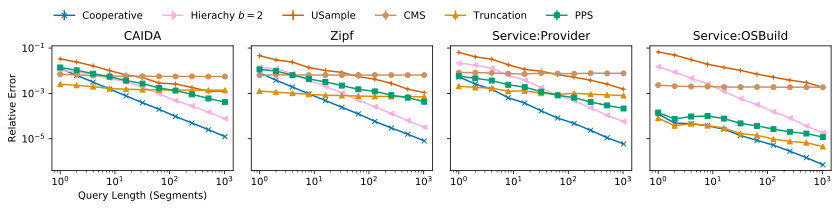

In [126]:
sketch_names = [
    "cooperative", 
    "dyadic_b2", 
#     "dyadic_b3",
    "random_sample", 
    "cms_min", 
    "truncation", 
    "pps"]
sketch_size = 64
h_datasets = [
    ("caida_10M", 2048), 
    ("zipf1p1_10M", 2048),
#     ("msft_records_3M", 2048)
    ("msft_network_3M", 2048),
    ("msft_os_3M", 2048),
]

fig, axs = plt.subplots(figsize=(14,2.3), nrows=1, ncols=4, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
for dataset_name, granularity in h_datasets:
    query_length_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_size,
        item_agg="max",
        query_agg="mean",
        ax=axs[di],
        absolute=False,
    )
    axs[di].set_title(data_display_name[dataset_name])
    di += 1

axs[0].set_xlabel("Query Length (Segments)")
axs[0].set_ylabel("Relative Error")

lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.35), ncol=6)
# fig.tight_layout()
fname = "output/plots/linear_freq.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

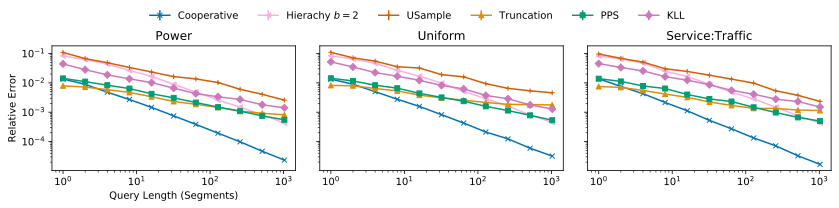

In [127]:
sketch_names = [
    "q_cooperative", 
    "q_dyadic_b2", 
    "q_random_sample", 
    "q_truncation", 
    "q_pps", 
    "kll"
]
sketch_size = 64
h_datasets = [
    ("power_2M", 2048),
    ("uniform_1M", 2048), 
    ("msft_records_3M", 2048),
]

fig, axs = plt.subplots(figsize=(14,2.3), nrows=1, ncols=3, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
egs = []
for dataset_name, granularity in h_datasets:
    ax1, eg1 = query_length_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_size,
        item_agg="max",
        query_agg="mean",
        ax=axs[di],
#         absolute=True
    )
    axs[di].set_title(data_display_name[dataset_name])
    egs.append(eg1)
    di += 1

axs[0].set_xlabel("Query Length (Segments)")
axs[0].set_ylabel("Relative Error")
# axs[0].set_ylim(10**-5, 1)

lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.35), ncol=6)
# fig.tight_layout()
fname = "output/plots/linear_quant.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [95]:
eg = egs[2].reset_index()
eg[eg["query_len"]==1024].sort_values(["err"])

sketch query_len    e_norm                           err  \
                                   mean       std       max             
21    q_cooperative      1024  0.000017  0.000003  0.000024  0.000017   
32      q_dyadic_b2      1024  0.000425  0.000052  0.000516  0.000425   
43            q_pps      1024  0.000500  0.000066  0.000589  0.000500   
65     q_truncation      1024  0.001144  0.000132  0.001390  0.001144   
10              kll      1024  0.001507  0.000193  0.001849  0.001507   
54  q_random_sample      1024  0.002328  0.000427  0.002851  0.002328   

     err_std  
              
21  0.000003  
32  0.000052  
43  0.000066  
65  0.000132  
10  0.000193  
54  0.000427

# Varying Space

In [96]:
def get_dyadic_size(s, granularity: int):
    return int(s / math.log(granularity, 2))

In [97]:
def query_size_plot(
    dataset_name,
    granularity,
    sketch_names: List,
    sketch_sizes: List,
    query_len:int,
    item_agg="mean",
    query_agg="mean",
    ax = None,
    normalize=True,
):
    e_dfs = []
    for cur_name in sketch_names:
        for cur_size in sketch_sizes:
            sketch_size = cur_size
            cur_file = get_error_file(
                dataset_name, granularity, cur_name, sketch_size
            )
            cur_df = pd.read_csv(cur_file)
            cur_df["size"] = cur_size
            e_dfs.append(cur_df)

    e_combined = pd.concat(e_dfs, axis=0)
    if normalize:
        e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    else:
        e_combined["e_norm"] = e_combined[item_agg]

    eg = e_combined.groupby([
        "query_len",
        "sketch",
        "size",
    ]).aggregate({
        "e_norm": ["mean", "std", "max"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"]
    
    for method in sketch_names:
        eg_cur = eg.loc[query_len,method]
        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
    #         markevery=2,
        )
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_title("Query Length: {}".format(query_len))

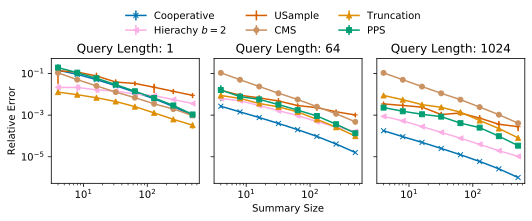

In [98]:
sketch_names = [
    "cooperative", 
    "dyadic_b2", 
    "random_sample", 
    "cms_min", 
    "truncation", 
    "pps"]
sketch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
# dataset_name = "zipf1p1_10M"
dataset_name = "caida_10M"
granularity = 2048
item_agg = "max"
query_agg = "mean"

query_lengths = [1, 64, 1024]

fig, axs = plt.subplots(figsize=(8.5,2.3), nrows=1, ncols=3, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0

for query_len in query_lengths:
    query_size_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_sizes,
        query_len = query_len,
        item_agg=item_agg,
        query_agg=query_agg,
        ax=axs[di],
        normalize=True
    )
    di += 1

axs[1].set_xlabel("Summary Size")
axs[0].set_ylabel("Relative Error")

lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.45), ncol=3)
fname = "output/plots/linear_freq_size.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Varying Dyadic Base

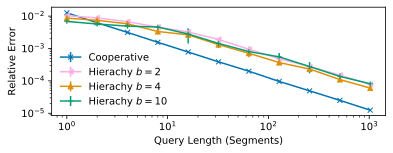

In [107]:
sketch_names = [
    "cooperative", 
    "dyadic_b2", 
    "dyadic_b4",
    "dyadic_b10",
]
sketch_size = 64
h_datasets = [
    ("caida_10M", 2048), 
#     ("zipf1p1_10M", 2048),
]

fig = plt.figure(figsize=(6,2))
ax = fig.gca()

di = 0
for dataset_name, granularity in h_datasets:
    query_length_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_size,
        item_agg="max",
        query_agg="mean",
        ax=ax
    )
    di += 1

ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Relative Error")

# lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.35), ncol=6)
lgd = ax.legend(frameon=False)
# fig.tight_layout()
fname = "output/plots/linear_freq_dyadic_base.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Varying Lookback Time

In [42]:
dataset_name = "caida_10M"
granularity = 2048
lookback_sizes = [8, 32, 128, 512, 2048]
sketch_size = 64
query_len = 64
item_agg = "max"
query_agg = "mean"

In [43]:
e_dfs = []
cur_name = "cooperative"
cur_size = sketch_size
for cur_look in lookback_sizes:
    cur_file = get_error_file(
        dataset_name, 
        granularity, 
        sketch_name="{}_b{}".format(cur_name, cur_look), 
        sketch_size=sketch_size
    )
    cur_df = pd.read_csv(cur_file)
    cur_df["size"] = cur_size
    cur_df["Tmax"] = cur_look
    e_dfs.append(cur_df)

e_combined = pd.concat(e_dfs, axis=0)
e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]

eg = e_combined.groupby([
    "Tmax",
]).aggregate({
    "e_norm": ["mean", "std", "max"],
})
eg["err"] = eg[("e_norm", query_agg)]
eg["err_std"] = eg["e_norm", "std"]

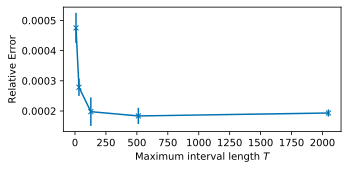

In [44]:
f = plt.figure(figsize=(5,2.3))
ax = f.gca()
ax.errorbar(
    eg.index, 
    eg["err"],
    yerr=eg["err_std"],
    label="Relative Error Distribution",
    marker="x",
    color="C0",
    markersize=5,
)
ax.set_xlabel("Maximum interval length $T$")
ax.set_ylabel("Relative Error")
fname = "output/plots/linear_freq_lookback.pdf"
f.savefig(fname, bbox_inches='tight')